<a href="https://colab.research.google.com/github/vedantdave77/project.Orca/blob/master/Generative%20Adversarial%20Networks/Batch_Normalization_Effect_on_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Batch Normalization

IN this notebook I will inplement layer level batch normalization in Neural Network. Its has huge impact on GAN performance. Here, my main motive is to understand the effect of batch transform on deep learning algorithm. And, will measure the performance difference. 

> It's called batch normalization because during training, we normalize each layer's inputs by using the mean and variance of the values in the current batch.

## Import Library

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline 

## Data Preparation



In [3]:
from torchvision import datasets
import torchvision.transforms as transforms

num_workers = 2
batch_size = 64
transform = transforms.ToTensor()

# Import data
train_data = datasets.MNIST(root = 'data', train=True, download=True, transform = transform)
test_data = datasets.MNIST(root = 'data', train=False, download=True, transform = transform)

# preparing  Data loader
train_loader = torch.utils.data.DataLoader(train_data,batch_size = batch_size, num_workers= num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, num_workers=num_workers)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Visualize data

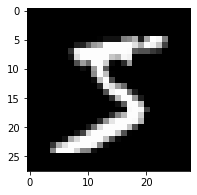

In [4]:
# obtain one batch of image
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (3,3)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

## Model Architecture

NeuralNet, allows us to create identical neural networks with and without batch normalization to compare. .

In [7]:
class Batch_Normalization(nn.Module):
  def __init__( self, use_batch_norm, input_size = 784, hidden_dim = 256, output_size = 10):
    super(Batch_Normalization,self).__init__()
    self.hidden_dim = hidden_dim
    self.input_size = input_size
    self.output_size = output_size
    self.use_batch_norm = use_batch_norm

    if use_batch_norm:
      self.fc1 = nn.Linear(input_size, hidden_dim*2, bias=False)
      self.batch_norm1 = nn.BatchNorm1d(hidden_dim*2)
    else:
      self.fc1 = nn.Linear(input_size,hidden_dim*2)

    if use_batch_norm:
      self.fc2 = nn.Linear(hidden_dim*2, hidden_dim,bias =False)
      self.batch_norm2 = nn.BatchNorm1d(hidden_dim)
    else:
      self.fc2 = nn.Linear(hidden_dim*2,hidden_dim)

    # third and final, fully-connected layer
    self.fc3 = nn.Linear(hidden_dim, output_size)

  def forward(self,x):
    # flatten image
    x = x.view(-1, 28*28)
    # --------------------------first_layer
    x = self.fc1(x)
    if self.use_batch_norm:
      x = self.batch_norm1(x)
    x = F.relu(x)
    # -------------------------- second_layer
    x = self.fc2(x)
    if self.use_batch_norm:
      x = self.batch_norm2(x)
    x = F.relu(x)
   # ---------------------------- third_layer
    x = self.fc3(x)
    return x 

## Model Testing  

Two different models for comparission.

In [8]:
NN_without_batchNorm = Batch_Normalization(use_batch_norm= False)
NN_with_batchNorm = Batch_Normalization(use_batch_norm= True)

print(NN_with_batchNorm) 
print()
print(NN_without_batchNorm)

Batch_Normalization(
  (fc1): Linear(in_features=784, out_features=512, bias=False)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=False)
  (batch_norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

Batch_Normalization(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


## Model Training

I will use cross entropy loss and stochastic gradient descent for optimization. And, will record the model behaviour after each epoch. So, its easy to compare.

In [21]:
def train(model, n_epochs=25):
  
  losses = []
  train_loss = 0.0
  batch_count = 0
  criterion = nn.CrossEntropyLoss()

  optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

  model.train()
  for epoch in range(1, n_epochs+1):
    for batch_id, (data,target) in enumerate(train_loader):
      optimizer.zero_grad()                                                     # grad_reset -> output -> loss -> loss-backward -> optimizer -> indi. loss update -> coutner update ->loos_update
      output = model(data)
      loss = criterion(output, target)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()
      batch_count += 1

    losses.append(train_loss/batch_count)
    print("Epoch: {} \tTraining_loss: {:.6f}".format(epoch, train_loss/batch_count))
  return losses

## Comparing Models

In the below cells, we train our two different models and compare their trainining loss over time.

In [22]:
loss_batchNorm = train(NN_with_batchNorm)

Epoch: 1 	Training_loss: 0.083981
Epoch: 2 	Training_loss: 0.074009
Epoch: 3 	Training_loss: 0.065888
Epoch: 4 	Training_loss: 0.059155
Epoch: 5 	Training_loss: 0.053485
Epoch: 6 	Training_loss: 0.048660
Epoch: 7 	Training_loss: 0.044524
Epoch: 8 	Training_loss: 0.040959
Epoch: 9 	Training_loss: 0.037870
Epoch: 10 	Training_loss: 0.035184
Epoch: 11 	Training_loss: 0.032834
Epoch: 12 	Training_loss: 0.030768
Epoch: 13 	Training_loss: 0.028940
Epoch: 14 	Training_loss: 0.027315
Epoch: 15 	Training_loss: 0.025862
Epoch: 16 	Training_loss: 0.024555
Epoch: 17 	Training_loss: 0.023376
Epoch: 18 	Training_loss: 0.022306
Epoch: 19 	Training_loss: 0.021330
Epoch: 20 	Training_loss: 0.020438
Epoch: 21 	Training_loss: 0.019619
Epoch: 22 	Training_loss: 0.018864
Epoch: 23 	Training_loss: 0.018166
Epoch: 24 	Training_loss: 0.017520
Epoch: 25 	Training_loss: 0.016918


In [23]:
loss_noNorm = train(NN_without_batchNorm)

Epoch: 1 	Training_loss: 0.513607
Epoch: 2 	Training_loss: 0.444898
Epoch: 3 	Training_loss: 0.406077
Epoch: 4 	Training_loss: 0.379381
Epoch: 5 	Training_loss: 0.358900
Epoch: 6 	Training_loss: 0.342107
Epoch: 7 	Training_loss: 0.327732
Epoch: 8 	Training_loss: 0.315081
Epoch: 9 	Training_loss: 0.303741
Epoch: 10 	Training_loss: 0.293449
Epoch: 11 	Training_loss: 0.284019
Epoch: 12 	Training_loss: 0.275315
Epoch: 13 	Training_loss: 0.267236
Epoch: 14 	Training_loss: 0.259703
Epoch: 15 	Training_loss: 0.252651
Epoch: 16 	Training_loss: 0.246026
Epoch: 17 	Training_loss: 0.239783
Epoch: 18 	Training_loss: 0.233886
Epoch: 19 	Training_loss: 0.228300
Epoch: 20 	Training_loss: 0.222998
Epoch: 21 	Training_loss: 0.217956
Epoch: 22 	Training_loss: 0.213151
Epoch: 23 	Training_loss: 0.208564
Epoch: 24 	Training_loss: 0.204180
Epoch: 25 	Training_loss: 0.199984


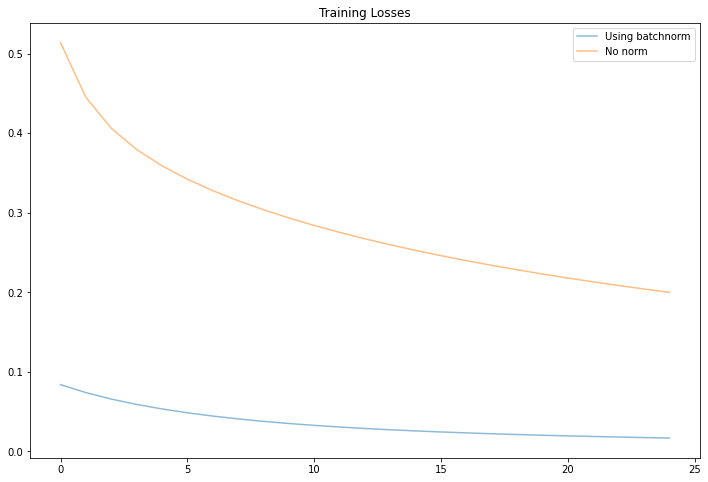

In [25]:
# compare
fig, ax = plt.subplots(figsize=(12,8))
#losses_batchnorm = np.array(losses_batchnorm)
#losses_no_norm = np.array(losses_no_norm)
plt.plot(loss_batchNorm, label='Using batchnorm', alpha=0.5)
plt.plot(loss_noNorm, label='No norm', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Testing 



In [48]:
def test(model,train):
  # initialize vars to monitor test loss and accuracy.
  class_correct = list(0. for i in range(10))
  class_total = list(0. for i in range(10))
  test_loss = 0.0

  # set model to train and validation mode.
  if(train == True):
    model.train()
  if(train == False):
    model.eval()

  # loss criterion
  criterion = nn.CrossEntropyLoss()

  for batch_idx, (data,target) in enumerate(test_loader):
    batch_size = data.size(0)
    output = model(data)
    loss = criterion(output,target)
    test_loss += loss.item()*batch_size
    _,pred = torch.max(output,1)
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))

    for i in range(batch_size):                                                 # calculate accuracy
      label = target.data[i]
      class_correct[label] += correct[i].item()
      class_total[label] += 1 
  print("Test Loss: {:.6f}\n".format(test_loss/len(test_loader.dataset)))

  for i in range(10):
    if class_total[i] > 0:
      print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                str(i+1), 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
      print('Test Accuracy of %5s: N/A (no training examples)' % (class_total[i]))

  print('\nTest Accuracy (Overall): %2f%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))

## Training and Evaluating Model (again)



In [49]:
test(NN_with_batchNorm, train = True)

Test Loss: 0.081112

Test Accuracy of     1: 99% (971/980)
Test Accuracy of     2: 99% (1124/1135)
Test Accuracy of     3: 96% (999/1032)
Test Accuracy of     4: 97% (985/1010)
Test Accuracy of     5: 97% (962/982)
Test Accuracy of     6: 97% (867/892)
Test Accuracy of     7: 97% (936/958)
Test Accuracy of     8: 97% (999/1028)
Test Accuracy of     9: 96% (943/974)
Test Accuracy of    10: 95% (968/1009)

Test Accuracy (Overall): 97.540000% (9754/10000)


In [50]:
test(NN_with_batchNorm, train = False)

Test Loss: 0.067948

Test Accuracy of     1: 98% (968/980)
Test Accuracy of     2: 99% (1124/1135)
Test Accuracy of     3: 97% (1011/1032)
Test Accuracy of     4: 97% (986/1010)
Test Accuracy of     5: 97% (962/982)
Test Accuracy of     6: 97% (873/892)
Test Accuracy of     7: 98% (941/958)
Test Accuracy of     8: 97% (998/1028)
Test Accuracy of     9: 96% (940/974)
Test Accuracy of    10: 97% (982/1009)

Test Accuracy (Overall): 97.850000% (9785/10000)


Conclusion: Here, in testing mode, the evaluation mode model gives littlebit highter accuracy than training mode model.

In [51]:
test(NN_without_batchNorm, train= False)

Test Loss: 0.110477

Test Accuracy of     1: 98% (964/980)
Test Accuracy of     2: 98% (1117/1135)
Test Accuracy of     3: 97% (1002/1032)
Test Accuracy of     4: 96% (976/1010)
Test Accuracy of     5: 96% (945/982)
Test Accuracy of     6: 97% (868/892)
Test Accuracy of     7: 96% (921/958)
Test Accuracy of     8: 96% (987/1028)
Test Accuracy of     9: 94% (925/974)
Test Accuracy of    10: 95% (959/1009)

Test Accuracy (Overall): 96.640000% (9664/10000)


But, the testign accuraccy of Model without Normalization will gives lower accuracy. 

In [52]:
# Keep Learning, Enjoy Empowering